D-Wave Inspector enabled.


Serving Inspector on http://127.0.0.1:18000/?problemId=c8cff03f-5087-4f66-960d-70fdccbd18d3

Embedding information is unavailable.


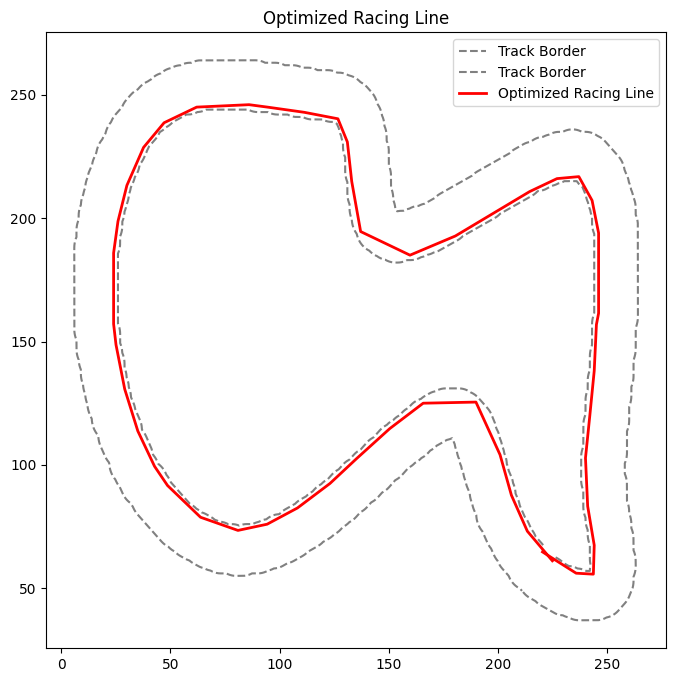

In [5]:
import math
import json
import numpy as np
from scipy import interpolate
from shapely.geometry import LineString
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.preprocessing import ScaleComposite
from dwave.embedding import embed_qubo, unembed_sampleset
from dimod import BinaryQuadraticModel
import networkx as nx
from dwave_networkx.drawing import draw_chimera
import matplotlib.pyplot as plt

# Import D-Wave Inspector
try:
    import dwave.inspector
    inspector_available = True
    print("D-Wave Inspector enabled.")
except ImportError:
    inspector_available = False
    print("D-Wave Inspector is not installed. Install it using `pip install dwave-inspector`.")

def plot_lines(track_lines, racing_line, title="Track"):
    """Plot track lines and overlay racing line."""
    plt.figure(figsize=(8, 8))

    # Plot track lines (inside and outside)
    for line in track_lines:
        x, y = line.xy
        plt.plot(x, y, label="Track Border", color="grey", linestyle="--")

    # Plot optimized racing line
    x_racing, y_racing = racing_line.xy
    plt.plot(x_racing, y_racing, label="Optimized Racing Line", color="red", linewidth=2)

    plt.title(title)
    plt.legend(loc="best")
    plt.show()

def visualize_embedding(response, bqm):
    """Visualize the embedding used by the sampler."""
    # Access the embedding from the sample set info
    embedding = response.info.get('embedding_context', {}).get('embedding', {})
    target_graph = response.info.get('embedding_context', {}).get('target_graph', nx.Graph())

    if not embedding or not target_graph:
        print("Embedding information is unavailable.")
        return

    # Create a visual graph of the embedding
    embedding_graph = nx.Graph()
    for qubit_chain in embedding.values():
        for i, qubit1 in enumerate(qubit_chain):
            for qubit2 in qubit_chain[i + 1:]:
                embedding_graph.add_edge(qubit1, qubit2)

    # Draw the embedding
    plt.figure(figsize=(12, 8))
    draw_chimera(target_graph, edgelist=embedding_graph.edges, node_size=50)
    plt.title("Embedding Visualization")
    plt.show()

def racing_line_qannealing(center_line, inside_line, outside_line, num_sectors=50, num_samples=1000, plot=True):
    """Optimize racing line using quantum annealing."""
    # Define sectors
    distances = np.linspace(0, center_line.length, num_sectors)
    center_points = [center_line.interpolate(dist) for dist in distances]
    center_points = np.array([[p.x, p.y] for p in center_points])

    inside_points = [
        get_closest_points(pt, np.array(inside_line.coords)) for pt in center_points
    ]
    outside_points = [
        get_closest_points(pt, np.array(outside_line.coords)) for pt in center_points
    ]

    # QUBO Construction
    num_variables = num_sectors * 10  # 10 binary variables per sector for discretization
    step_size = 1 / 10  # Each binary variable represents 0.1 of the sector width

    bqm = BinaryQuadraticModel('BINARY')

    # Objective: Minimize lap time
    for sector_idx in range(num_sectors):
        for i in range(10):
            weight = step_size * (i + 0.5)  # Midpoint value for binary variables
            bqm.add_variable(sector_idx * 10 + i, weight)

    # Constraints: One-hot encoding (only one binary variable per sector can be 1)
    for sector_idx in range(num_sectors):
        sector_vars = [sector_idx * 10 + i for i in range(10)]
        bqm.add_linear_equality_constraint(
            [(var, 1) for var in sector_vars], constant=-1, lagrange_multiplier=10
        )

    # Scale the QUBO for better performance
    scaled_sampler = ScaleComposite(DWaveSampler(token="API TOKEN GOES HERE"))  # Replace with your API key
    sampler = EmbeddingComposite(scaled_sampler)

    # Run on D-Wave
    sampleset = sampler.sample(
        bqm, 
        num_reads=num_samples,
        chain_strength=15,  # Adjust chain strength
        annealing_time=50   # Test with longer annealing time
    )

    # Open the Inspector with the sampleset if available
    if inspector_available:
        dwave.inspector.show(sampleset)  # This will open the Inspector in your default browser

    # Visualize the embedding after sampling
    visualize_embedding(sampleset, bqm)

    # Extract best solution
    best_solution = sampleset.first.sample
    sectors = [
        sum((best_solution[sector_idx * 10 + i] * step_size for i in range(10)))
        for sector_idx in range(num_sectors)
    ]

    # Generate racing line
    racing_line = sectors_to_racing_line(sectors, inside_points, outside_points)

    # Plot final racing line
    if plot:
        plot_lines([inside_line, outside_line], LineString(racing_line), title="Optimized Racing Line")

    return racing_line

def main():
    # Load track data
    with open("data/tracks.json") as file:
        data = json.load(file)
    track_data = data["test_track"]

    # Extract track layout
    track_layout = np.array(track_data["layout"])
    track_width = track_data["width"]

    # Create track borders
    center_line = LineString(track_layout)
    inside_line = center_line.parallel_offset(track_width / 2, 'left')
    outside_line = center_line.parallel_offset(track_width / 2, 'right')

    # Run optimization
    racing_line = racing_line_qannealing(center_line, inside_line, outside_line)

if __name__ == "__main__":
    main()
